# NDVI Timeseries

This notebook presents an application case, that demonstrates how to display the NDVI (Normalized Difference Vegetation Index) timeseries for specific fields. The case study showcases the process of selecting the fields and generating average NDVI timeseries data for analysis and visualization. 

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import shapely.geometry
import json
import scipy.signal
import numpy as np

import openeo
from openeo.rest.conversions import timeseries_json_to_pandas

In [4]:
# defining the plotting function

DEFAULT_FIGSIZE = (5, 4)


def plot_timeseries(filename):
    """Helper to plot the timeseries directly from JSON file"""
    with open(filename) as f:
        ts = timeseries_json_to_pandas(json.load(f)).dropna()
    ts.index = pd.to_datetime(ts.index)
    fig, ax = plt.subplots(figsize=DEFAULT_FIGSIZE)
    ts.plot(marker="o", ax=ax)
    ax.set_title("Average NDVI")
    ax.set_ylabel("NDVI")
    ax.set_ylim(0, 1)
    ax.legend(title="parcel id", loc="lower left", ncol=2)

In [5]:
# connect to the backend and authenticate

connection = openeo.connect(url="openeo.dataspace.copernicus.eu").authenticate_oidc()

Authenticated using refresh token.


let's calculate a time series of the average NDVI in a couple of fields in this area.

First, load the fields as shapely geometries:

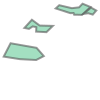

In [6]:
fields_geojson = '{"type": "GeometryCollection", "geometries": [{"type": "Polygon", "coordinates": [[[5.055945487931457, 51.222709834076504], [5.064972484168688, 51.221122565090525], [5.064972484168688, 51.221122565090525], [5.067474954083448, 51.218249806779134], [5.064827929485983, 51.21689628072789], [5.05917785594747, 51.217191909908095], [5.053553857094518, 51.21807492332223], [5.055945487931457, 51.222709834076504]]]}, {"type": "Polygon", "coordinates": [[[5.063345886679116, 51.23087606640057], [5.06604742694687, 51.22886710731809], [5.070627820472246, 51.22874440121892], [5.068403609708207, 51.22657208381529], [5.064823257492447, 51.22676051738515], [5.064892324615199, 51.2283032878514], [5.063641745941974, 51.2285757299238], [5.062340811262595, 51.227722351687945], [5.06076005158084, 51.228042312276536], [5.063345886679116, 51.23087606640057]]]}, {"type": "Polygon", "coordinates": [[[5.07163184674986, 51.23481147556147], [5.076706025697324, 51.23317590781036], [5.077828303041866, 51.233226237184724], [5.078024733866917, 51.23263978271262], [5.080771081607657, 51.23259097170763], [5.083734842574312, 51.23530464074437], [5.080957826735458, 51.23646091560258], [5.079752631651647, 51.23519531038643], [5.077238400183506, 51.23490534677628], [5.072856439300575, 51.23593546777778], [5.07163184674986, 51.23481147556147]]]}, {"type": "Polygon", "coordinates": [[[5.083897244679042, 51.23510639883143], [5.081302408741335, 51.232922477780846], [5.082963802194108, 51.233146058575876], [5.084497702305552, 51.232672717580655], [5.085732850338428, 51.2340852086282], [5.083897244679042, 51.23510639883143]]]}]}'
fields = shapely.geometry.shape(json.loads(fields_geojson))
fields

We want to calculate the NDVI for a larger time window covering of a couple of months.

Also note that we don't have to specify a bounding box explicitly when loading the cube,
because we will pass the desired fields in a next step, 
and the backend will limit the data loading to those areas appropriately.

In [7]:
dates = ("2020-06-01", "2020-10-01")

cube = connection.load_collection(
                "SENTINEL2_L2A", temporal_extent=dates, bands=["B04", "B08", "SCL"]
)

red = cube.band("B04")
nir = cube.band("B08")
ndvi = (nir - red) / (nir + red)

With the `DataCube.aggregate_spatial()` method , we can calculate the mean NDVI for each of the fields.

In [8]:
timeseries = ndvi.aggregate_spatial(geometries=fields, reducer="mean")

We trigger execution by downloading the result. 
Because `DataCube.aggregate_spatial()` returns a timeseries (instead of raster data), we download it in JSON format.

In [9]:
timeseries.download("output/timeseries.json")

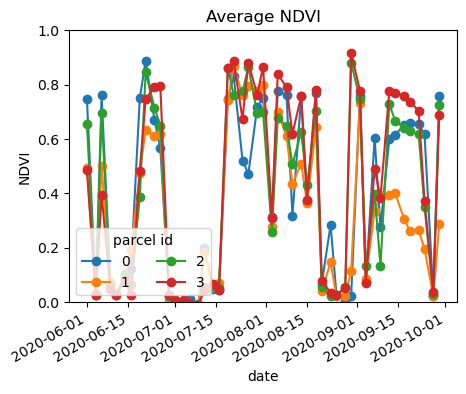

In [10]:
plot_timeseries( "output/timeseries.json")

The result above is a good start, but needs some work: there are quite some outliers and zero's that don't look right.

To filter out the cloudy pixels: we create a cloud mask based on the scene classification band on which gaussian filter is applied.

By convolving the mask with the kernel, the values of neighboring pixels are taken into account when determining whether a pixel should be classified as cloud or non-cloud. This improves the accuracy of the cloud mask by considering the spatial context of each pixel in relation to its surroundings.

Therefore, we need a simple gaussian kernel:

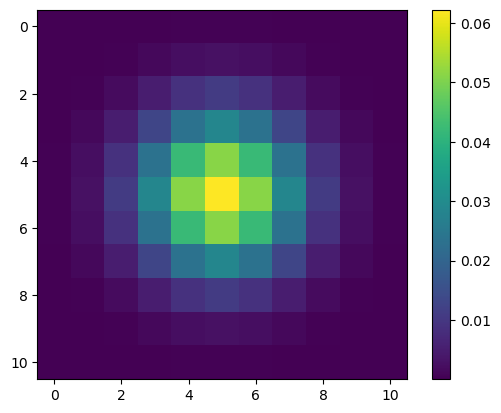

In [11]:
g = scipy.signal.windows.gaussian(11, std=1.6)
kernel = np.outer(g, g)
kernel = kernel / kernel.sum()
im = plt.imshow(kernel)
plt.colorbar(im)

In [12]:
classification = cube.band("SCL")
mask = ~((classification == 4) | (classification == 5))
mask = mask.apply_kernel(kernel)
mask = mask > 0.1

masked_ndvi = ndvi.mask(mask)

In [13]:
masked_timeseries = masked_ndvi.aggregate_spatial(geometries=fields, reducer="mean")
masked_timeseries.download("output/timeseries-masked.json")

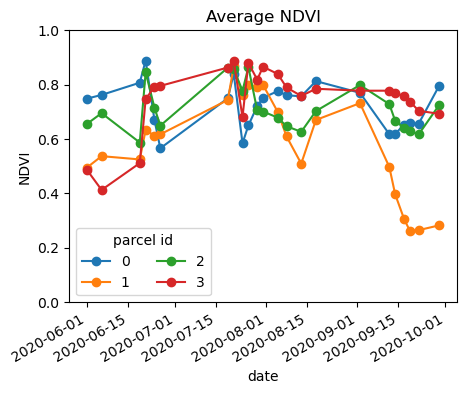

In [14]:
plot_timeseries( "output/timeseries-masked.json")

# Timeseries Smoothing

Furthermore with an aim to improve the plot's smoothness by using a kernel, in this notebook we define a kernel as an smoothening UDF. The kernel will help to reduce noise and fluctuations in the data, resulting in a smoother and more accurate representation of the NDVI timeseries.

Here We define an UDF (user-defined function)
to interpolate the missing values 
and to apply a Savitzky-Golay filter for smoothing of the timeseries, using `scipy.signal.savgol_filter`.

In [15]:
udf = openeo.UDF(
    """
from scipy.signal import savgol_filter
from openeo.udf import XarrayDataCube

def apply_datacube(cube: XarrayDataCube, context: dict) -> XarrayDataCube:
    array = cube.get_array()
    filled = array.interpolate_na(dim='t')
    smoothed_array = savgol_filter(filled.values, 5, 2, axis=0)
    return DataCube(xarray.DataArray(smoothed_array, dims=array. dims,coords=array.coords))
"""
)

smoothed_ndvi = masked_ndvi.apply_dimension(code=udf, dimension="t")

Now, aggregate this again per field and get the time series.

In [16]:
smoothed_timeseries = smoothed_ndvi.aggregate_spatial(geometries=fields, reducer="mean")

In [17]:
smoothed_timeseries.download("output/timeseries-smoothed.json")

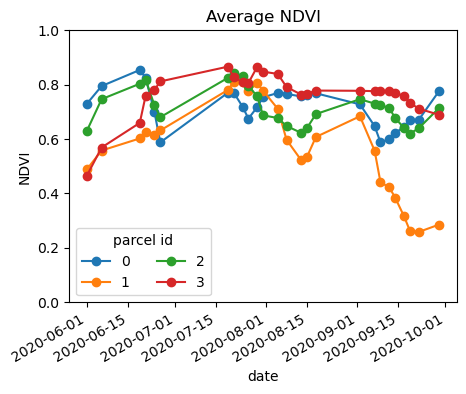

In [18]:
plot_timeseries("output/timeseries-smoothed.json")